In [1]:
# Notebook 1: Exploration des données brutes - Tunisie complète

import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import numpy as np
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")

print("=== EXPLORATION DES DONNÉES BRUTES - ML-TuniMapAi (TUNISIE COMPLÈTE) ===")
print()

=== EXPLORATION DES DONNÉES BRUTES - ML-TuniMapAi (TUNISIE COMPLÈTE) ===



In [ ]:
import json
import pandas as pd


# === 1. CHARGEMENT DES DONNÉES ===
def load_municipalities_and_delegations(json_file_path):
    """
    Charge un fichier JSON contenant toutes les municipalités et leurs délégations.
    Retourne :
      - municipalities : liste de dicts (chaque municipalité avec ses 'Delegations')
      - delegations_df : DataFrame plat avec chaque délégation et infos parent
    """ 
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    all_delegations = []
    municipalities = []

    # Normaliser la structure en liste de municipalités
    if isinstance(data, dict):
        municipalities = [data]
    elif isinstance(data, list):
        municipalities = data
    else:
        raise ValueError("Format JSON inconnu")

    # Construire DataFrame
    for muni in municipalities:
        muni_name = muni.get('Name', 'Unknown')
        muni_name_ar = muni.get('NameAr', '')
        muni_val = muni.get('Value', '')
        delegations = muni.get('Delegations', [])

        # Si aucune délégation, créer une ligne vide avec infos gouvernorat
        if not delegations:
            all_delegations.append({
                'Governorate': muni_name,
                'GovernorateAr': muni_name_ar,
                'GovernorateValue': muni_val
            })
        else:
            for delg in delegations:
                row = delg.copy()
                # Ajouter les colonnes standardisées
                row['Governorate'] = muni_name
                row['GovernorateAr'] = muni_name_ar
                row['GovernorateValue'] = muni_val
                all_delegations.append(row)

    delegations_df = pd.DataFrame(all_delegations)

    # Sécurité : vérifier si les colonnes existent et les créer sinon
    for col in ['Governorate', 'GovernorateAr', 'GovernorateValue']:
        if col not in delegations_df.columns:
            delegations_df[col] = 'Unknown'

    return municipalities, delegations_df

# Charger le JSON
municipalities, delegations_df = load_municipalities_and_delegations(
    '../data/raw/state-municipality-areas.json'
)

# Vérifier les colonnes et lignes
print("Colonnes disponibles :", delegations_df.columns.tolist())
print("Nombre de lignes :", len(delegations_df))
print(delegations_df.head())

Colonnes disponibles : ['Name', 'NameAr', 'Value', 'PostalCode', 'Latitude', 'Longitude', 'Governorate', 'GovernorateAr', 'GovernorateValue']
Nombre de lignes : 4788
                                Name                          NameAr  \
0   ARIANA VILLE (Residence Kortoba)    أريانة المدينة (إقامة قرطبة)   
1  ARIANA VILLE (Cite El Intissar 1)  أريانة المدينة (حي الإنتصار 1)   
2      SIDI THABET (Borj El Khoukha)          سيدي ثابت (برج الخوخة)   
3        LA SOUKRA (Cite Ezzitoun 1)             سكرة (حي الزيتون 1)   
4      ARIANA VILLE (Riadh Landlous)   أريانة المدينة (رياض الأندلس)   

          Value PostalCode   Latitude  Longitude Governorate GovernorateAr  \
0  ARIANA VILLE       2058  36.866011  10.193923      ARIANA        أريانة   
1  ARIANA VILLE       2091  36.871532  10.175512      ARIANA        أريانة   
2   SIDI THABET       2032  36.933000  10.039000      ARIANA        أريانة   
3     LA SOUKRA       2036  36.885212  10.245301      ARIANA        أريانة   
4  ARIANA V

In [16]:
# === 2. ANALYSE GLOBALE DES DONNÉES ===
print("\n2. ANALYSE GLOBALE DES DONNÉES DE TUNISIE")
print("-" * 60)

# Répartition par gouvernorat
print("Répartition par gouvernorat:")
gov_counts = delegations_df['Governorate'].value_counts()
print(gov_counts.head(10))
print()

# Statistiques des coordonnées
if 'Latitude' in delegations_df.columns and 'Longitude' in delegations_df.columns:
    print("Statistiques des coordonnées:")
    print(delegations_df[['Latitude', 'Longitude']].describe())
    print()

    # Étendue géographique
    print("Étendue géographique:")
    print(f"Latitude: {delegations_df['Latitude'].min():.4f} à {delegations_df['Latitude'].max():.4f}")
    print(f"Longitude: {delegations_df['Longitude'].min():.4f} à {delegations_df['Longitude'].max():.4f}")
else:
    print("⚠ Les colonnes 'Latitude' et 'Longitude' sont manquantes dans le DataFrame.")


2. ANALYSE GLOBALE DES DONNÉES DE TUNISIE
------------------------------------------------------------
Répartition par gouvernorat:
Governorate
NABEUL         351
BEN AROUS      317
SFAX           317
BEJA           310
SIDI BOUZID    262
KEF            260
BIZERTE        251
ARIANA         208
SILIANA        201
TUNIS          197
Name: count, dtype: int64

Statistiques des coordonnées:
          Latitude    Longitude
count  4788.000000  4788.000000
mean     35.722579     9.880298
std       1.169970     0.752435
min      30.273600     7.816700
25%      34.866700     9.247800
50%      35.983300    10.070600
75%      36.725600    10.490800
max      37.301500    11.533300

Étendue géographique:
Latitude: 30.2736 à 37.3015
Longitude: 7.8167 à 11.5333


In [17]:
# 3. VISUALISATIONS
print("3. VISUALISATIONS DES DONNÉES")
print("-" * 60)

3. VISUALISATIONS DES DONNÉES
------------------------------------------------------------


Text(0.5, 0.98, 'Analyse des données de Tunisie - ML-TuniMapAi')

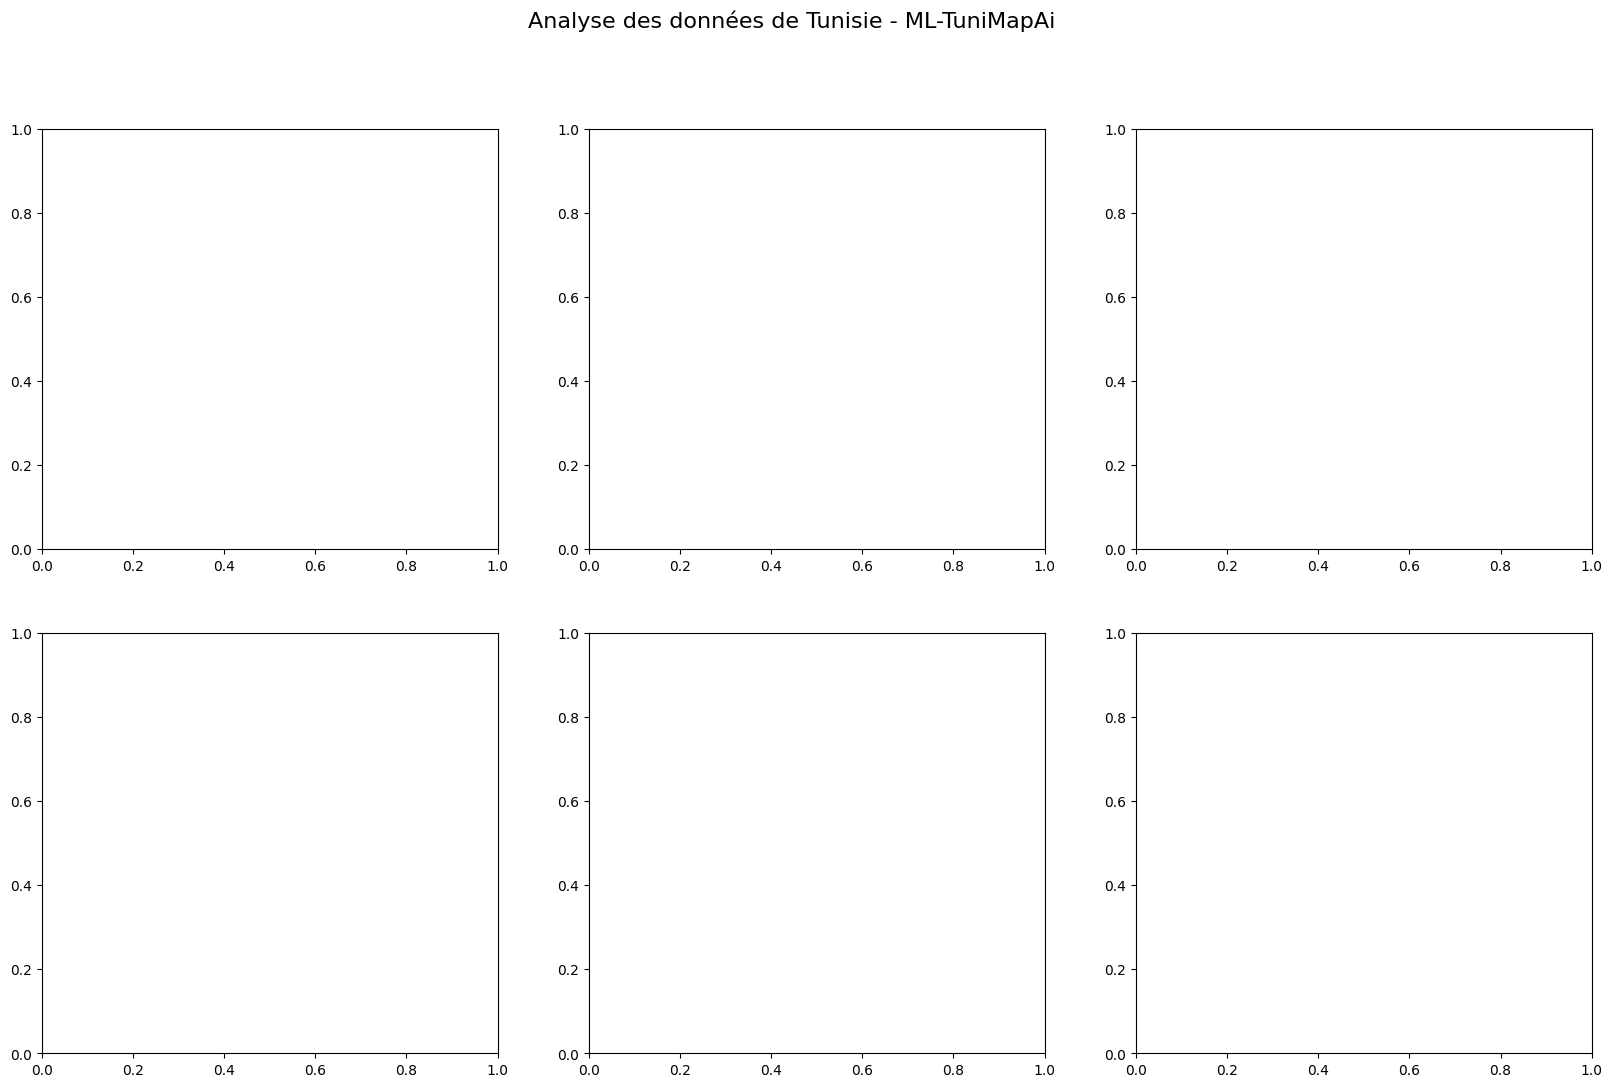

In [18]:
# Configuration des graphiques
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Analyse des données de Tunisie - ML-TuniMapAi', fontsize=16)

In [19]:
# Graphique 1: Top gouvernorats par nombre de délégations
top_gov = gov_counts.head(10)
axes[0, 0].bar(range(len(top_gov)), top_gov.values, color='skyblue', edgecolor='black')
axes[0, 0].set_xticks(range(len(top_gov)))
axes[0, 0].set_xticklabels(top_gov.index, rotation=45, ha='right', fontsize=10)
axes[0, 0].set_title('Top 10 Gouvernorats par nombre de délégations', fontsize=12)
axes[0, 0].set_ylabel('Nombre de délégations', fontsize=10)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)


In [20]:
# Graphique 2: Distribution des latitudes
axes[0, 1].hist(delegations_df['Latitude'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 1].set_title('Distribution des Latitudes', fontsize=12)
axes[0, 1].set_xlabel('Latitude', fontsize=10)
axes[0, 1].set_ylabel('Fréquence', fontsize=10)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.6)

In [21]:
# Graphique 3: Distribution des longitudes
axes[0, 2].hist(delegations_df['Longitude'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 2].set_title('Distribution des Longitudes', fontsize=12)
axes[0, 2].set_xlabel('Longitude', fontsize=10)
axes[0, 2].set_ylabel('Fréquence', fontsize=10)
axes[0, 2].grid(axis='y', linestyle='--', alpha=0.6)

In [22]:
import numpy as np

# Graphique 4: Scatter plot de toutes les coordonnées (Top 20 gouvernorats)
colors = plt.cm.tab20(np.linspace(0, 1, len(gov_counts)))
top_govs = gov_counts.index[:20]

for i, gov in enumerate(top_govs):
    gov_data = delegations_df[delegations_df['Governorate'] == gov]
    axes[1, 0].scatter(
        gov_data['Longitude'], gov_data['Latitude'],
        c=[colors[i]], label=gov, alpha=0.6, s=35, edgecolor='k', linewidth=0.5
    )

axes[1, 0].set_title('Distribution géographique par gouvernorat', fontsize=12)
axes[1, 0].set_xlabel('Longitude', fontsize=10)
axes[1, 0].set_ylabel('Latitude', fontsize=10)
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1, 0].grid(True, linestyle='--', alpha=0.5)


In [23]:
# Graphique 5: Heatmap des coordonnées
hb = axes[1, 1].hexbin(
    delegations_df['Longitude'], delegations_df['Latitude'],
    gridsize=25, cmap='YlOrRd', mincnt=1
)
axes[1, 1].set_title('Densité géographique (Heatmap)', fontsize=12)
axes[1, 1].set_xlabel('Longitude', fontsize=10)
axes[1, 1].set_ylabel('Latitude', fontsize=10)
axes[1, 1].grid(True, linestyle='--', alpha=0.3)

# Ajouter une colorbar
cb = fig.colorbar(hb, ax=axes[1, 1])
cb.set_label('Nombre de délégations', fontsize=10)


In [24]:
# Graphique 6: Distribution des codes postaux (top 10 préfixes)
postal_distribution = delegations_df['PostalCode'].astype(str).str[:2].value_counts().head(10)
axes[1, 2].bar(
    range(len(postal_distribution)),
    postal_distribution.values,
    color='mediumpurple',
    edgecolor='black'
)
axes[1, 2].set_xticks(range(len(postal_distribution)))
axes[1, 2].set_xticklabels(postal_distribution.index, rotation=45, ha='right', fontsize=10)
axes[1, 2].set_title('Top 10 Préfixes de codes postaux', fontsize=12)
axes[1, 2].set_ylabel('Fréquence', fontsize=10)
axes[1, 2].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<Figure size 640x480 with 0 Axes>

In [27]:
print(delegations_df.columns.tolist())


['Name', 'NameAr', 'Value', 'PostalCode', 'Latitude', 'Longitude', 'Governorate', 'GovernorateAr', 'GovernorateValue']


In [28]:
import folium
from folium import plugins
import os

print("4. CRÉATION DE LA CARTE INTERACTIVE DE TUNISIE")
print("-" * 60)

# Centre de la Tunisie
tunisia_center = [34.5, 9.5]

# Création de la carte principale
m = folium.Map(location=tunisia_center, zoom_start=7, tiles='OpenStreetMap')

# Couleurs distinctes pour chaque gouvernorat
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
          'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 
          'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 
          'lightgray', 'brown', 'cyan', 'magenta', 'yellow', 'lime']

unique_govs = delegations_df['Governorate'].unique()
color_map = {gov: colors[i % len(colors)] for i, gov in enumerate(unique_govs)}

# Ajout des marqueurs par gouvernorat avec clustering
marker_cluster = plugins.MarkerCluster().add_to(m)

for idx, row in delegations_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=4,
        popup=f"<b>{row['Name']}</b><br>"
              f"Gouvernorat: {row['Governorate']}<br>"
              f"Code postal: {row['PostalCode']}<br>"
              f"Coordonnées: {row['Latitude']:.4f}, {row['Longitude']:.4f}",
        color=color_map[row['Governorate']],
        fill=True,
        fillColor=color_map[row['Governorate']],
        fillOpacity=0.6,
        weight=1
    ).add_to(marker_cluster)

# Ajout de la heatmap de densité
heat_data = delegations_df[['Latitude', 'Longitude']].values.tolist()
plugins.HeatMap(heat_data).add_to(m)

# Sauvegarde de la carte
os.makedirs('../data/visualizations', exist_ok=True)
m.save('../data/visualizations/tunisia_complete_map.html')
print("✓ Carte complète sauvegardée: '../data/visualizations/tunisia_complete_map.html'")


4. CRÉATION DE LA CARTE INTERACTIVE DE TUNISIE
------------------------------------------------------------
✓ Carte complète sauvegardée: '../data/visualizations/tunisia_complete_map.html'


In [29]:
# 5. ANALYSE DES DISTANCES ET CONNECTIVITÉ
print("\n5. ANALYSE DES DISTANCES ET CONNECTIVITÉ")
print("-" * 60)

from geopy.distance import geodesic

def calculate_distances_matrix_sample(df, sample_size=100):
    """
    Calcule une matrice de distances pour un échantillon de points
    """
    if len(df) > sample_size:
        sample_df = df.sample(sample_size, random_state=42)
    else:
        sample_df = df
    
    distances = []
    for i, row1 in sample_df.iterrows():
        for j, row2 in sample_df.iterrows():
            if i != j:
                dist = geodesic((row1['Latitude'], row1['Longitude']),
                               (row2['Latitude'], row2['Longitude'])).kilometers
                distances.append({
                    'from_id': i,
                    'to_id': j,
                    'from_name': row1['Name'],
                    'to_name': row2['Name'],
                    'from_gov': row1['Governorate'],
                    'to_gov': row2['Governorate'],
                    'distance_km': dist
                })
    
    return pd.DataFrame(distances)

# Calcul d'un échantillon de distances
print("Calcul des distances pour un échantillon de 50 points...")
distances_sample = calculate_distances_matrix_sample(delegations_df, 50)

print(f"Matrice de distances créée: {len(distances_sample)} paires")
print("\nStatistiques des distances:")
print(distances_sample['distance_km'].describe())

# Distances les plus longues et les plus courtes
print("\nTop 5 distances les plus longues:")
longest = distances_sample.nlargest(5, 'distance_km')
for _, row in longest.iterrows():
    print(f"{row['from_gov']} -> {row['to_gov']}: {row['distance_km']:.2f} km")

print("\nTop 5 distances les plus courtes (hors 0):")
shortest = distances_sample[distances_sample['distance_km'] > 0].nsmallest(5, 'distance_km')
for _, row in shortest.iterrows():
    print(f"{row['from_name']} -> {row['to_name']}: {row['distance_km']:.2f} km")

print()


5. ANALYSE DES DISTANCES ET CONNECTIVITÉ
------------------------------------------------------------
Calcul des distances pour un échantillon de 50 points...
Matrice de distances créée: 2450 paires

Statistiques des distances:
count    2450.000000
mean      169.483219
std       105.317265
min         0.000000
25%        86.653866
50%       150.526747
75%       246.147096
max       443.392731
Name: distance_km, dtype: float64

Top 5 distances les plus longues:
BIZERTE -> MEDENINE: 443.39 km
MEDENINE -> BIZERTE: 443.39 km
MEDENINE -> BIZERTE: 429.59 km
BIZERTE -> MEDENINE: 429.59 km
BIZERTE -> KEBILI: 426.75 km

Top 5 distances les plus courtes (hors 0):
HAMMAM LIF (Cite Essanaoubria) -> HAMMAM LIF (Cite Des Instituteurs): 0.19 km
HAMMAM LIF (Cite Des Instituteurs) -> HAMMAM LIF (Cite Essanaoubria): 0.19 km
LA SOUKRA (Residence 26-26) -> LA SOUKRA (Cite Chouachia): 0.52 km
LA SOUKRA (Cite Chouachia) -> LA SOUKRA (Residence 26-26): 0.52 km
EL MOUROUJ (Residence El Mourjene) -> EL MOUROU

In [32]:
import os
import pandas as pd

print("6. SAUVEGARDE DES DONNÉES PRÉPROCESSÉES")
print("-" * 60)

# Création du dossier si nécessaire
os.makedirs('../data/processed', exist_ok=True)

# Sauvegarde du DataFrame principal des délégations
delegations_df.to_csv('../data/processed/tunisia_delegations.csv', index=False, encoding='utf-8')
print("✓ Délégations sauvegardées: '../data/processed/tunisia_delegations.csv'")

# Informations sur les gouvernorats
governorates_summary = delegations_df.groupby('Governorate').agg(
    delegation_count=('Name', 'count'),
    center_lat=('Latitude', 'mean'),
    center_lon=('Longitude', 'mean')
).reset_index()

governorates_summary.to_csv('../data/processed/governorates_summary.csv', index=False, encoding='utf-8')
print("✓ Résumé gouvernorats sauvegardé: '../data/processed/governorates_summary.csv'")

# Sauvegarde de l'échantillon de distances
distances_sample.to_csv('../data/processed/distances_sample.csv', index=False, encoding='utf-8')
print("✓ Échantillon distances sauvegardé: '../data/processed/distances_sample.csv'")

6. SAUVEGARDE DES DONNÉES PRÉPROCESSÉES
------------------------------------------------------------
✓ Délégations sauvegardées: '../data/processed/tunisia_delegations.csv'
✓ Résumé gouvernorats sauvegardé: '../data/processed/governorates_summary.csv'
✓ Échantillon distances sauvegardé: '../data/processed/distances_sample.csv'


In [33]:
# 7. RÉSUMÉ FINAL
print("\n7. RÉSUMÉ DE L'EXPLORATION")
print("-" * 60)

# Calculs utiles
unique_governorates = delegations_df['Governorate'].unique()
gov_counts = delegations_df['Governorate'].value_counts()

summary = f"""
RÉSUMÉ DES DONNÉES TUNISIE COMPLÈTE - ML-TuniMapAi:

COUVERTURE GÉOGRAPHIQUE:
- Nombre total de délégations: {len(delegations_df)}
- Nombre de gouvernorats: {len(unique_governorates)}
- Étendue latitude: {delegations_df['Latitude'].min():.4f} à {delegations_df['Latitude'].max():.4f}
- Étendue longitude: {delegations_df['Longitude'].min():.4f} à {delegations_df['Longitude'].max():.4f}

TOP 5 GOUVERNORATS:
{chr(10).join([f"- {gov}: {count} délégations" for gov, count in gov_counts.head(5).items()])}

STATISTIQUES DES DISTANCES:
- Distance moyenne: {distances_sample['distance_km'].mean():.2f} km
- Distance maximale: {distances_sample['distance_km'].max():.2f} km
- Distance minimale (>0): {distances_sample[distances_sample['distance_km'] > 0]['distance_km'].min():.2f} km

FICHIERS GÉNÉRÉS:
- tunisia_delegations.csv: Données principales
- governorates_summary.csv: Résumé par gouvernorat
- distances_sample.csv: Échantillon de distances
- tunisia_complete_map.html: Carte interactive

PROCHAINES ÉTAPES:
1. Prétraitement avancé et nettoyage
2. Construction de la matrice complète des temps de trajet
3. Intégration des données OSM pour les routes
4. Développement des modèles ML de prédiction
5. Création de l'interface Streamlit
"""

print(summary)

# Sauvegarde du résumé
import os
os.makedirs('../data/processed', exist_ok=True)
with open('../data/processed/tunisia_exploration_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n✓ Exploration terminée! Résumé sauvegardé dans '../data/processed/tunisia_exploration_summary.txt'")
print("✓ Prêt pour l'étape de prétraitement (notebook 02)")



7. RÉSUMÉ DE L'EXPLORATION
------------------------------------------------------------

RÉSUMÉ DES DONNÉES TUNISIE COMPLÈTE - ML-TuniMapAi:

COUVERTURE GÉOGRAPHIQUE:
- Nombre total de délégations: 4788
- Nombre de gouvernorats: 24
- Étendue latitude: 30.2736 à 37.3015
- Étendue longitude: 7.8167 à 11.5333

TOP 5 GOUVERNORATS:
- NABEUL: 351 délégations
- BEN AROUS: 317 délégations
- SFAX: 317 délégations
- BEJA: 310 délégations
- SIDI BOUZID: 262 délégations

STATISTIQUES DES DISTANCES:
- Distance moyenne: 169.48 km
- Distance maximale: 443.39 km
- Distance minimale (>0): 0.19 km

FICHIERS GÉNÉRÉS:
- tunisia_delegations.csv: Données principales
- governorates_summary.csv: Résumé par gouvernorat
- distances_sample.csv: Échantillon de distances
- tunisia_complete_map.html: Carte interactive

PROCHAINES ÉTAPES:
1. Prétraitement avancé et nettoyage
2. Construction de la matrice complète des temps de trajet
3. Intégration des données OSM pour les routes
4. Développement des modèles ML de p